# Indexování v NumPy v praxi
Jako první krok načteme knihovny Numpy a Matplotlib pro vizualizaci.

In [1]:
### 
import numpy as np
import matplotlib.pyplot as plt

## 1. Indexování booleovským polem
Úkol: nakreslete sinusovku takm aby se zobrazovaly pouze kladné půlperiody (jako po průchodu diodou). Dále čárkovanou čarou doplňte chybějící záporné půlperiody.

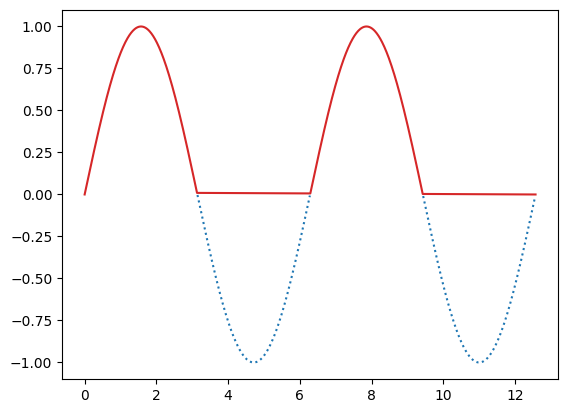

In [2]:
# vytvoříme si pole x a y pro vykreslení
x = np.linspace(0, 4*np.pi, 1000)
y = np.sin(x)

# vytvoříme pole "neg" které říká, zda jsme 
# v druhé půlperiodě (x % 2pi > pi)
neg = np.mod(x, 2*np.pi) > np.pi

# Zobrazíme pouze kladné periody
plt.plot(x[~neg], y[~neg], c="tab:red")

# Vytvoříme si pole y2, které v kladných polohách bude nulové
y2 = y.copy()
y2[~neg] = np.nan # todo: nahradit za np.nan a zkusit výsledke
plt.plot(x, y2, c="tab:blue", ls=":")


## 2. Fancy indexing
Ukázka indexování polem. Vytvoříme si na začátku pole náhodných bodů (2D)

In [3]:
###
X = np.random.multivariate_normal([0, 0], [[1, 2], [2, 5]], 100)

Vykreslíme body a náhodně zakroužkujeme 10 bodů

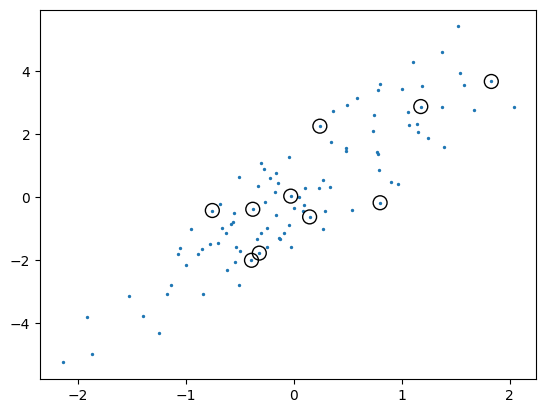

In [4]:
# Vybereme indexy pro kroužkování jako 10 ze 100 bodů
indices = np.random.choice(100, 10)
indices

# Vykreslime body - musíme správně extratovat x a y hodnoty
plt.scatter(X[:, 0], X[:, 1], s = 2)
plt.scatter(X[indices, 0], X[indices, 1], facecolor="none", ec="k", s=100)

Dále chceme zobrazit všechny body z X, které jsou uvnitř kružnice o středu [0, 0] a vzdálenosti 1

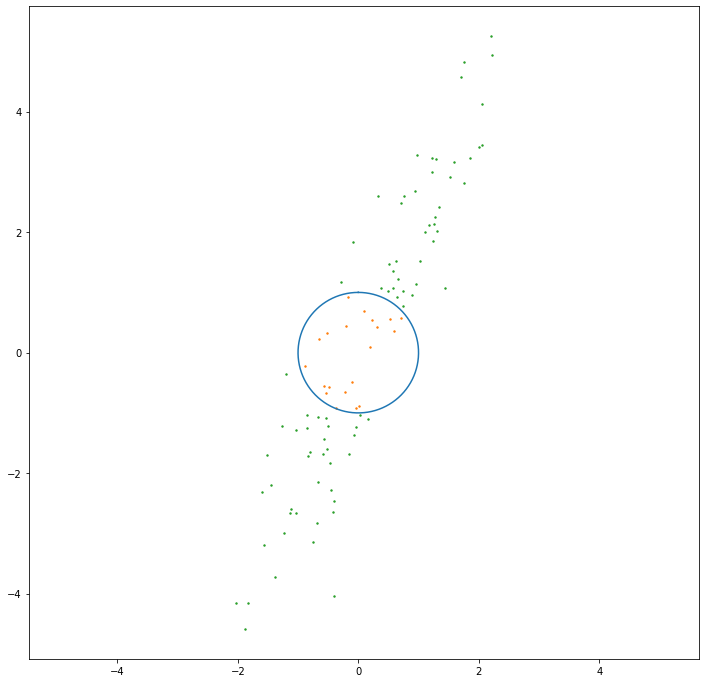

In [25]:
# Vytvoříme si bool pole in_circle, které říká, že x**2 + y**2 < 1**2
in_circle = (X[:, 0]**2 + X[:, 1]**2) < 1**2
in_circle ###

# Vykreslime body
plt.figure(figsize=(12, 12))
plt.scatter(X[~in_circle, 0], X[~in_circle, 1], s = 2, c="tab:green") ###
plt.scatter(X[in_circle, 0], X[in_circle, 1], s=2, c="tab:orange") ###


plt.axis("equal") ###

# vykreslime kruh (matematicky vypocet, samozrejme je mozne pouzit i 
# plt.Circle a ax.add_patch())
j = np.linspace(0, 2*np.pi, 100)
plt.plot(np.sin(j), np.cos(j))

## 3. Hledač min
Mějme 2D pole s 0 a jedničkou 1. Určíme, kolik má každá buňka min vedle sebe. **Pro jednoduchost se budeme dívat jen doleva a doprava ***

In [26]:
###
# Vytvoříme si počáteční pole
X = np.random.choice([0, 1], size=(8,8))
X

array([[0, 0, 0, 0, 0, 1, 0, 1],
       [0, 1, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 1, 0, 1, 0],
       [1, 0, 1, 1, 0, 1, 1, 0],
       [1, 1, 1, 0, 1, 1, 1, 0],
       [0, 0, 1, 0, 1, 1, 0, 1],
       [0, 0, 1, 1, 1, 0, 1, 0],
       [1, 1, 1, 1, 0, 1, 1, 0]])

In [27]:
# Vytvořit pole nul (Y) pro výsledky (jako X)
Y = np.zeros_like(X)
# Vypočítat všechny vnitřní sloupce
Y[:, 1:-1] += X[:, :-2] + X[:, 2:]
# Vypočítat kraje
Y[:, 0] += X[:, 1]
Y[:, -1] += X[:, -1]
Y ###

array([[0, 0, 0, 0, 1, 0, 2, 1],
       [1, 0, 1, 0, 1, 1, 1, 0],
       [0, 0, 0, 1, 0, 2, 0, 0],
       [0, 2, 1, 1, 2, 1, 1, 0],
       [1, 2, 1, 2, 1, 2, 1, 0],
       [0, 1, 0, 2, 1, 1, 2, 1],
       [0, 1, 1, 2, 1, 2, 0, 0],
       [1, 2, 2, 1, 2, 1, 1, 0]])

# Heating equation

Výpočet ohřívání destičky podle toho, jak se v ní šíří teplota. Ukázka čerpá z následujícího [zdroje](https://scipython.com/book/chapter-7-matplotlib/examples/the-two-dimensional-diffusion-equation/)

Nastavíme tedy počáteční podmínky (desku bodů)

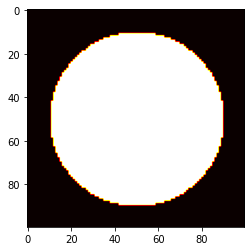

In [28]:
###
# plate size, mm
w = h = 10.
# intervals in x-, y- directions, mm
dx = dy = 0.1
# Thermal diffusivity of steel, mm2.s-1
D = 4.

Tcool, Thot = 100, 700

nx, ny = int(w/dx), int(h/dy)

dx2, dy2 = dx*dx, dy*dy
dt = dx2 * dy2 / (2 * D * (dx2 + dy2))

u0 = Tcool * np.ones((nx, ny))
u = u0.copy()

# Initial conditions - circle of radius r centred at (cx,cy) (mm)
r, cx, cy = 4, 5, 5
r2 = r**2
for i in range(nx):
   for j in range(ny):
        p2 = (i*dx-cx)**2 + (j*dy-cy)**2
        if p2 < r2:
            u0[i,j] = Thot
plt.imshow(u0, cmap=plt.get_cmap('hot'), vmin=Tcool,vmax=Thot)


A provedeme výpočet podle numerické difuzní rovnice

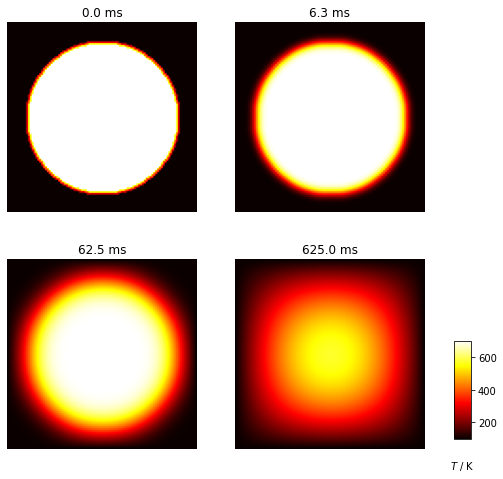

In [29]:
###
def do_timestep(u0, u):
    # Propagate with forward-difference in time, central-difference in space
    u[1:-1, 1:-1] = u0[1:-1, 1:-1] + D * dt * (
          (u0[2:, 1:-1] - 2*u0[1:-1, 1:-1] + u0[:-2, 1:-1])/dx2
          + (u0[1:-1, 2:] - 2*u0[1:-1, 1:-1] + u0[1:-1, :-2])/dy2 )

    u0 = u.copy()
    return u0, u

# Number of timesteps
# Output 4 figures at these timesteps
mfig = [0, 10, 100, 1000]
nsteps = max(mfig) + 1
fignum = 0
fig = plt.figure(figsize=(8, 8))
for m in range(nsteps):
    u0, u = do_timestep(u0, u)
    if m in mfig:
        fignum += 1
        ax = fig.add_subplot(220 + fignum)
        im = ax.imshow(u.copy(), cmap=plt.get_cmap('hot'), vmin=Tcool,vmax=Thot)
        ax.set_axis_off()
        ax.set_title('{:.1f} ms'.format(m*dt*1000))
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.17])
cbar_ax.set_xlabel('$T$ / K', labelpad=20)
fig.colorbar(im, cax=cbar_ax)
plt.show()